# Imports and loading data

In [ ]:
!pip install pyod

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pyhf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pyhf
import matplotlib.pyplot as plt
import numpy as np
from pyod.models.iforest import IForest
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
tf.random.set_seed(2)
import pandas as pd
import sys
import math
import random
import timeit
import seaborn as sns
sns.set_style("white")
import os
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Since we dont have RAM capacity to read the entire Background file we will choose randomly 1500000 events from the file

In [ ]:
def sample_n_from_csv(filename:str, n:int=100, total_rows:int=None) -> pd.DataFrame:
    if total_rows==None:
        with open(filename,"r") as fh:
            total_rows = sum(1 for row in fh)
    if(n>total_rows):
        print("Error: n > total_rows", file=sys.stderr)
    skip_rows =  random.sample(range(1,total_rows+1), total_rows-n)
    return pd.read_csv(filename, skiprows=skip_rows)

In [ ]:
Signal = pd.read_csv("/content/drive/MyDrive/MASH/ResmMed4000mX1lb0p2yp0p4.csv")
Background = sample_n_from_csv("/content/drive/MyDrive/MASH/bkg.csv", n=1500000)

# Pre-processing data

In [ ]:
Signal['label'] = 1
Background['label'] = 0

data = pd.concat([Signal, Background],ignore_index=True)

train_features = ['MET', 'MET_Phi', 'isOdd', 'isBlind', 'nGoodJets',
       'nGoodbJets', 'nGoodlJets', 'nGoodtoplJets', 'nForwardJets',
       'nTruthJets', 'jet_pt', 'jet_e', 'jet_eta', 'jet_phi', 'ljet_pt',
       'topjet_pt', 'ljet_e', 'topjet_e', 'ljet_m', 'topjet_m', 'ljet_eta',
       'topjet_eta', 'ljet_phi', 'topjet_phi', 'fjet_pt', 'fjet_e', 'fjet_eta',
       'fjet_phi', 'DeltaPhi_MET_ljet', 'Omega', 'DeltaPhi_MET_calojets',
       'MT_JMET', 'HT', 'mtop', 'DeltaPt_top_jets', 'DeltaE_top_jets',
       'DeltaPt_top_jetsbjet', 'DeltaE_top_jetsbjet', 'DeltaE_tot',
       'DeltaPhi_bjet_topjet', 'Centrality', 'Centrality2', 'Centrality3',
       'DeltaR_max', 'MT_bMET_min', 'DeltaR_bjet_topjet', 'DeltaPhi_MET_fjet',
       'DeltaPhi_fjet_calojets', 'DeltaPt_fjet_jets', 'DeltaPt_fjet_bjet',
       'DeltaPt_fjet_top', 'DeltaE_fjet_jets', 'DeltaE_fjet_jetsbjet',
       'DeltaR_fjet_topjet', 'DeltaR_bjet_fjet', 'DeltaEta_fjet_topjet',
       'DeltaEta_fjet_bjet', 'DeltaEta_fjet_jet', 'jet_DL1r', 'jet_DL1r_max',
       'jet_DL1r_max2', 'jet_DL1r_bin', 'jet_DL1r_max_bin',
       'jet_DL1r_max2_bin', 'ttbar_category', 'vjets_category','jet_px', 'jet_py', 'jet_pz', 'ljet_px',
       'ljet_py', 'ljet_pz', 'fjet_px', 'fjet_py', 'fjet_pz', 'MET_m',
       'MET_eta', 'MET_px', 'MET_py']

Background_train = Background[Background['gen_split'] == 'train']
Signal_train = Signal[Signal['gen_split'] == 'train']
y_train = Background_train['label']
y_train_s =Signal_train['label']
Background_train = Background_train[train_features]
Signal_train = Signal_train[train_features]

data_val = data[data['gen_split'] == 'val']
y_val = data_val['label']
data_val = data_val[train_features]

data_test = data[data['gen_split'] == 'test']
y_test = data_test['label']
data_test = data_test[train_features]

# Standardise
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
pca = PCA()

Background_train_std = scaler.fit_transform(Background_train)
Signal_train_std = scaler.fit_transform(Signal_train)
data_val_std   = scaler.transform(data_val)
data_test_std  = scaler.transform(data_test)

Background_train_std_pca = pca.fit_transform(Background_train_std)
Signal_train_std_pca = pca.transform(Signal_train_std)
data_val_std_pca   = pca.transform(data_val_std)
data_test_std_pca  = pca.transform(data_test_std)


# Anomaly Detection Technique - iForest

In [ ]:
# train IForest detector
clf_name = 'IForest'
clf = IForest(contamination=0.0001,n_estimators = 100 , max_features = 3)
clf.fit(Background_train)

print(clf.get_params())

# example of the feature importance
feature_importance = clf.feature_importances_
print("Feature importance", feature_importance)

NameError: ignored

In [ ]:
# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores2 = clf.decision_scores_  # raw outlier scores
y_train_scores = (y_train_scores2 - y_train_scores2.min())/(y_train_scores2.max() - y_train_scores2.min()) # outlier scores as a classifier

# get the prediction on the test data
#y_val_pred = clf.predict(Background_train)  # outlier labels (0 or 1)
#y_val_scores = clf.decision_function(Background_train)  # outlier scores

# get the prediction on the test data
y_val_pred = clf.predict(data_val)  # outlier labels (0 or 1)
y_val_scores2 = clf.decision_function(data_val)  # outlier scores
y_val_scores = (y_val_scores2 - y_val_scores2.min())/(y_val_scores2.max() - y_val_scores2.min()) # outlier scores as a classifier


# get the prediction on the test data
y_val2_pred = clf.predict(Signal_train)  # outlier labels (0 or 1)
y_val2_scores2 = clf.decision_function(Signal_train)  # outlier scores
y_val2_scores = (y_val_scores2 - y_val_scores2.min())/(y_val_scores2.max() - y_val_scores2.min()) # outlier scores as a classifier

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


In [ ]:
bins = plt.hist(y_train_scores2[np.where(y_train == 0)], bins=50, density=True, histtype='step', label='bkg train')
plt.hist(y_val_scores2[np.where(y_val == 1)], bins=bins[1], density=True, histtype='step', label='signal val')
plt.hist(y_val_scores2[np.where(y_val == 0)], bins=bins[1], density=True, histtype='step', label='bkg val')
plt.hist(y_val2_scores2[np.where(y_train_s == 1)], bins=bins[1], density=True, histtype='step', label='signal val 2')

plt.xlabel('IForest raw scores')
plt.legend(loc='upper left')
plt.show()

In [ ]:
bins = plt.hist(y_val_scores[np.where(y_val == 1)], bins=50, density=True, histtype='step', label='signal val')
plt.hist(y_train_scores[np.where(y_train == 0)], bins[1], density=True, histtype='step', label='bkg train')
plt.hist(y_val_scores[np.where(y_val == 0)], bins=bins[1], density=True, histtype='step', label='bkg val')
plt.hist(y_val2_scores[np.where(y_train_s == 1)], bins=bins[1], density=True, histtype='step', label='signal val 2')

plt.xlim(0,0.8)
plt.xlabel('IForest output')
plt.legend(loc='upper left')
plt.show()

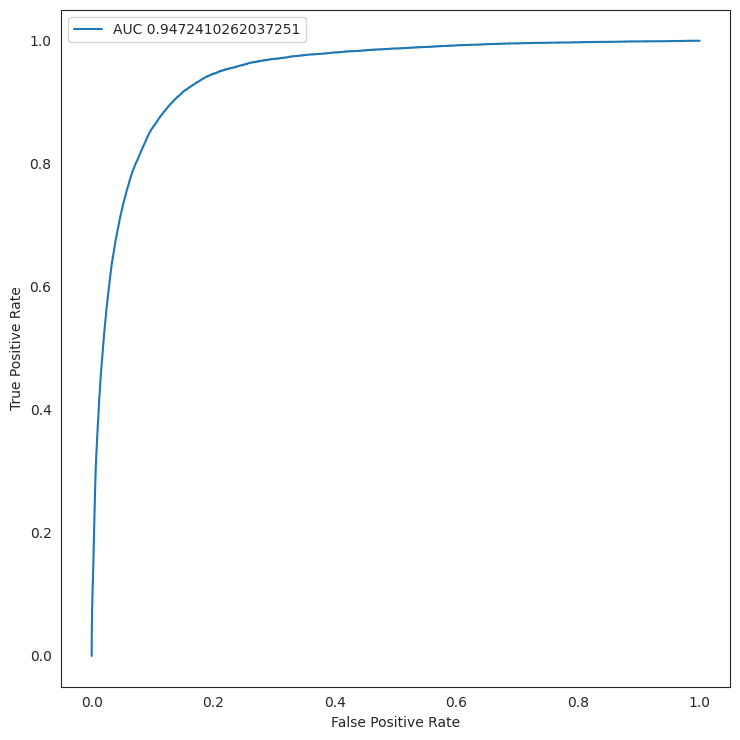

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_val, y_val_scores)
auc = roc_auc_score(y_val, y_val_scores)
plt.plot(fpr,tpr,label=f'AUC {auc}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [ ]:
def significance(s, b):
    if s + b == 0:
        return 0.0  # Handle the case when both s and b are zero to avoid division by zero
    try:
        sig = math.sqrt(2*(s+b)*math.log(1+s/b)-2*s)
        return sig if not np.isnan(sig) else 0
    except ValueError:
        return 0.0  # Handle other potential invalid calculations, such as taking the square root of a negative number

max 108.21783450468764 mt cut at 0.4408163265306123


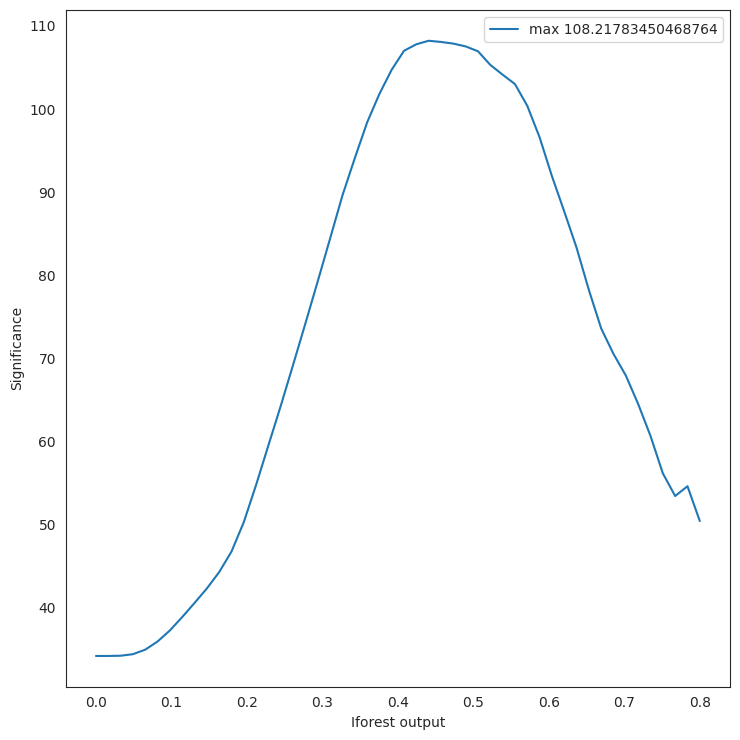

In [ ]:
def find_local_maxima(arr):
    local_maxima = []
    for i in range(1, len(arr) - 1):
        if arr[i] > arr[i - 1] and arr[i] > arr[i + 1]:
            local_maxima.append(arr[i])
    return local_maxima

sig = []
cuts = np.linspace(0,0.8,50)
for j in cuts:
  s =  np.count_nonzero(y_val_scores[np.where(y_val == 1)] > j)
  b =  np.count_nonzero(y_val_scores[np.where(y_val == 0)] > j)
  #print(s , b)
  sig = np.append(sig, significance(s,b))


print(f'max {max(sig)} mt cut at {cuts[np.argmax(sig)]}')

max_abs = cuts[np.argmax(sig)]

small_max = cuts[np.where(sig == find_local_maxima(sig)[0])]

plt.plot(np.linspace(0,0.8,50),sig,label=f'max {max(sig)}')
plt.xlabel('Iforest output')
plt.ylabel('Significance')
plt.legend()
plt.show()

In [ ]:
# VALIDATION PLOTS
plt.rcParams["figure.figsize"] = [7.50, 7.50]
plt.rcParams["figure.autolayout"] = True

#I THINK IT IS BETTER TO CHOOSE WHAT YOU WANT TO SEE:
feature1 = 'MET'
feature2 = 'jet_e'

# Extract the features from data_val
X_val = data_val[feature1].values
Y_val = data_val[feature2].values

# Plot the points SCORES
#plt.subplot(412)
#plt.scatter(X_val, Y_val, s=2, c=y_val_scores, cmap='coolwarm')

# Set labels and title
#plt.title('Validation scores')
#plt.xlabel(feature1)
#plt.ylabel(feature2)
#plt.xlim(X_val.min(), X_val.max())
#plt.ylim(Y_val.min(), Y_val.max())

#Ciclo para nosso predict
y_val_pred_mine = []
for i in range((len(y_val_scores))):
  if (y_val_scores[i] > small_max): y_val_pred_mine = np.append(y_val_pred_mine, 1)
  if (y_val_scores[i] <= small_max): y_val_pred_mine = np.append(y_val_pred_mine, 0)

In [ ]:
# Plot the points TRUE
plt.subplot(411)
plt.scatter(X_val, Y_val, s=2, c=y_val, cmap='coolwarm', alpha=0.1)

# Set labels and title
plt.title('Validation true')
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.xlim(X_val.min(), 3500)
plt.ylim(Y_val.min(), Y_val.max())
# Plot the points CLASSIFICATION Mine

plt.subplot(412)


plt.scatter(X_val, Y_val, s=2, c=y_val_pred_mine, cmap='coolwarm', alpha=0.1)

# Set labels and title
plt.title('Validation classified OUR')
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.xlim(X_val.min(), 3500)
plt.ylim(Y_val.min(), Y_val.max())

# Plot the points CLASSIFICATION
#plt.subplot(414)

#X_aux = []
#Y_aux = []
#for i in range((len(y_val_pred))):
#  if (y_val_pred[i] == 1 ):
#    X_aux = np.append(X_aux, X_val[i])
#    Y_aux = np.append(Y_aux, Y_val[i])
#plt.scatter(X_aux, Y_aux, s=2, color = 'red', alpha=0.1)

# Set labels and title
#plt.title('Validation classified')
#plt.xlim(X_val.min(), X_val.max())
#plt.ylim(Y_val.min(), Y_val.max())
#plt.xlabel(feature1)
#plt.ylabel(feature2)


# Show the plot
plt.show()

#for i in np.linspace(0,0.8,50):
#  print(i, np.count_nonzero(y_val_scores > i))


print(f'Outliers at TRUE: {np.count_nonzero(y_val == 1)} \nOutliers at CLASSIFIED: {np.count_nonzero(y_val_pred == 1)} \nScores > {small_max} : {np.count_nonzero(y_val_scores > small_max)} , \nScores > {max_abs} {np.count_nonzero(y_val_scores > max_abs)}')

print(np.count_nonzero(y_val_scores > small_max)/np.count_nonzero(y_val == 1))

In [ ]:
test_weights_df = data[data['gen_split'] == 'test']
test_weights_df_s = test_weights_df[test_weights_df['label'] == 1]
test_weights_s = []
test_weights_s = test_weights_df_s['normalisedCombinedWeight'].values
test_weights_df_b = test_weights_df[test_weights_df['label'] == 0]
test_weights_b = []
test_weights_b = test_weights_df_b['normalisedCombinedWeight'].values
test_weights_t = []
test_weights_t = test_weights_df['normalisedCombinedWeight'].values

In [ ]:
y_test_pred = clf.predict(data_test)  # outlier labels (0 or 1)
y_test_scores2 = clf.decision_function(data_test)  # outlier scores
y_test_scores = (y_test_scores2 - y_test_scores2.min())/(y_test_scores2.max() - y_test_scores2.min()) # outlier scores as a classifier

In [ ]:
y_test_scores_bkg = np.squeeze(y_test_scores[np.where(y_test == 0)])
y_test_scores_sig = np.squeeze(y_test_scores[np.where(y_test == 1)])

print(len(y_test_scores[np.where(y_test == 0)]))
print(len(test_weights_b))

bins= plt.hist(y_test_scores_bkg, bins=50, weights= test_weights_b, histtype='bar', stacked=True, fill=True, color=['blue'],label=['bkg'])
bin_counts_b, bin_edges_b, _ = plt.hist(y_test_scores[np.where(y_test == 0)],bins=bins[1],weights=test_weights_b, histtype='step', color='white')
bin_centres = (bin_edges_b[:-1] + bin_edges_b[1:]) / 2
y_error = np.sqrt(bin_counts_b)
#plt.errorbar(x=bin_centres, y=bin_counts,
#            yerr=y_error, color='black', fmt='o', capsize=2, label='data')



bins = plt.hist(y_test_scores_sig, bins=bins[1], weights= test_weights_s, histtype='bar', stacked=True, fill=True, color=['gold'],label=['sig'])
bin_counts_s, bin_edges_s , _ = plt.hist(y_test_scores[np.where(y_test == 1)],bins=bins[1],weights=test_weights_s, histtype='step', color='white')
bin_centres = (bin_edges_s[:-1] + bin_edges_s[1:]) / 2
y_error = np.sqrt(bin_counts_s)
#plt.errorbar(x=bin_centres, y=bin_counts,
#             yerr=y_error, color='black', fmt='o', capsize=2, label='data')


bin_counts_t, bin_edges_t , _ = plt.hist(y_test_scores,bins=bins[1],weights=test_weights_t, histtype='step', color='black')
bin_centres = (bin_edges_t[:-1] + bin_edges_t[1:]) / 2
y_error = np.sqrt(bin_counts_t)
#plt.errorbar(x=bin_centres, y=bin_counts,
#             yerr=y_error, color='black', fmt='o', capsize=2, label='data')

plt.legend()
plt.xlabel('Score histogram test sample')
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.show()

In [ ]:
bck = np.histogram(y_test_scores_bkg, bins=50, weights= test_weights_b)
bck_count, bck_edges = np.histogram(y_test_scores_bkg, bins=50, weights= test_weights_b)
bck_centres = (bck_edges[:-1] + bck_edges[1:])/ 2
bck_width = np.diff(bck_edges)[0]
plt.bar(bck_centres,bck_count, label = 'bkg', color = 'blue', width = bck_width)

sig = np.histogram(y_test_scores_sig, bins=50, weights= test_weights_s)
sig_count, sig_edges = np.histogram(y_test_scores_sig, bins=50, weights= test_weights_s)
plt.bar(bck_centres, sig_count, label = 'sig', color = 'gold', width = bck_width, bottom =bck_count)


tot = np.histogram(y_test_scores, bins=50, weights= test_weights_t)
tot_edges = tot[1].tolist()

plt.hist(y_test_scores, bins=bck[1],weights=test_weights_t, histtype='step',label = 'total ', color='black')

plt.legend()
plt.xlabel("Score histogram stacked")
plt.yscale('log')
plt.show()

#plt.hist([y_test_pred_bkg,y_test_pred_sig], bins=50, weights= [test_weights_s,test_weights_b], histtype='bar', stacked=True, fill=True, color=['gold','blue'],label=['bkg','sig'])
#plt.legend()
#plt.yscale('log')  # Set y-axis to logarithmic scale
#plt.show()

In [ ]:
from keras import backend
model_spec = {'channels': [{'name': 'singlechannel',
              'samples': [
              {'name': 'signal','data': sig[0].tolist() ,
               'modifiers': [{'data': None, 'name': 'mu', 'type': 'normfactor'}]},
              {'name': 'bkg','data': bck[0].tolist() ,
               'modifiers': [#{'data': None, 'name': 'bkg1_scale', 'type': 'normfactor'}, # Normalisation factor for bkg1
                            ]},
              ]
              }],
              "observations": [{ "name": "singlechannel", "data": tot[0].tolist() }],
              "measurements": [{ "name": "Measurement", "config": {"poi": "mu", "parameters": []}}],
              "version": "1.0.0",
}

workspace = pyhf.Workspace(model_spec)
model = workspace.model()

print("## Model")
print(f"  channels: {model.config.channels}")
print(f"     nbins: {model.config.channel_nbins}")
print(f"   samples: {model.config.samples}")
print(f" modifiers: {model.config.modifiers}")
print(f"parameters: {model.config.parameters}")
print(f"par. order: {model.config.par_order}")

print("\n## Model parameters")
print(f'   default: {model.config.suggested_init()}')
print(f'    bounds: {model.config.suggested_bounds()}')

In [ ]:
data = bck[0].tolist() + model.config.auxdata

best_pars = pyhf.infer.mle.fit(data=data, pdf=model)
print("\nBest fit parameters:")
for i,p in enumerate(best_pars):
  print(f'\t{model.config.par_order[i]}: {best_pars[i]:.2e}')


test_stat = "qtilde"
test_poi = 1.

# Vary mu values
poi_values = np.linspace(0.1, 5, 50)
obs_limit, exp_limits = pyhf.infer.intervals.upperlimit(data, model, poi_values, level=0.05)
print(f"Observed μ upper limit (obs): {obs_limit:.3f}, Expected μ upper limit {exp_limits[2]:.3f}")


Best fit parameters:
	mu: 1.42e-14


<ipython-input-54-43ec16e57746>:14: DeprecationWarning: pyhf.infer.intervals.upperlimit is deprecated in favor of pyhf.infer.intervals.upper_limits.upper_limit as of pyhf v0.7.0 and will be removed in pyhf v0.9.0. Please use pyhf.infer.intervals.upper_limits.upper_limit.
  obs_limit, exp_limits = pyhf.infer.intervals.upperlimit(data, model, poi_values, level=0.05)


Observed μ upper limit (obs): 1.437, Expected μ upper limit 1.437


In [ ]:
data = tot[0].tolist() + model.config.auxdata

best_pars = pyhf.infer.mle.fit(data=data, pdf=model)
print("\nBest fit parameters:")
for i,p in enumerate(best_pars):
  print(f'\t{model.config.par_order[i]}: {best_pars[i]:.2e}')


test_stat = "qtilde"
test_poi = 1.

# Vary mu values
poi_values = np.linspace(0.1, 5, 50)
obs_limit, exp_limits = pyhf.infer.intervals.upperlimit(data, model, poi_values, level=0.05)
print(f"Observed μ upper limit (obs): {obs_limit:.3f}, Expected μ upper limit {exp_limits[2]:.3f}")

# Anomaly Detection Technique - HBOS

In [ ]:
from pyod.models.hbos import HBOS
# train HBOS detector
clf2 = HBOS(n_bins=20, alpha=0.5, tol=0.01, contamination=0.01)
clf2.fit(Background_train)

# get the prediction labels and outlier scores of the training data
y_train_pred = clf2.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores2 = clf2.decision_scores_  # raw outlier scores
y_train_scores = (y_train_scores - y_train_scores.min())/(y_train_scores.max() - y_train_scores.min()) # outlier scores as a classifier

# get the prediction on the test data
#y_val_pred = clf.predict(Background_train)  # outlier labels (0 or 1)
#y_val_scores = clf.decision_function(Background_train)  # outlier scores

# get the prediction on the test data
y_val_pred = clf2.predict(data_val)  # outlier labels (0 or 1)
y_val_scores2 = clf2.decision_function(data_val)  # outlier scores
y_val_scores = (y_val_scores2 - y_val_scores2.min())/(y_val_scores2.max() - y_val_scores2.min()) # outlier scores as a classifier

print(clf2.get_params())

In [ ]:
bins = plt.hist(y_train_scores2[np.where(y_train == 0)], bins=50, density=True, histtype='step', label='bkg train')
plt.hist(y_val_scores2[np.where(y_val == 1)], bins=bins[1], density=True, histtype='step', label='signal val')
plt.hist(y_val_scores2[np.where(y_val == 0)], bins=bins[1], density=True, histtype='step', label='bkg val')

plt.xlabel('HBOS raw scores')
plt.legend(loc='upper left')
plt.show()

/usr/local/lib/python3.10/dist-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


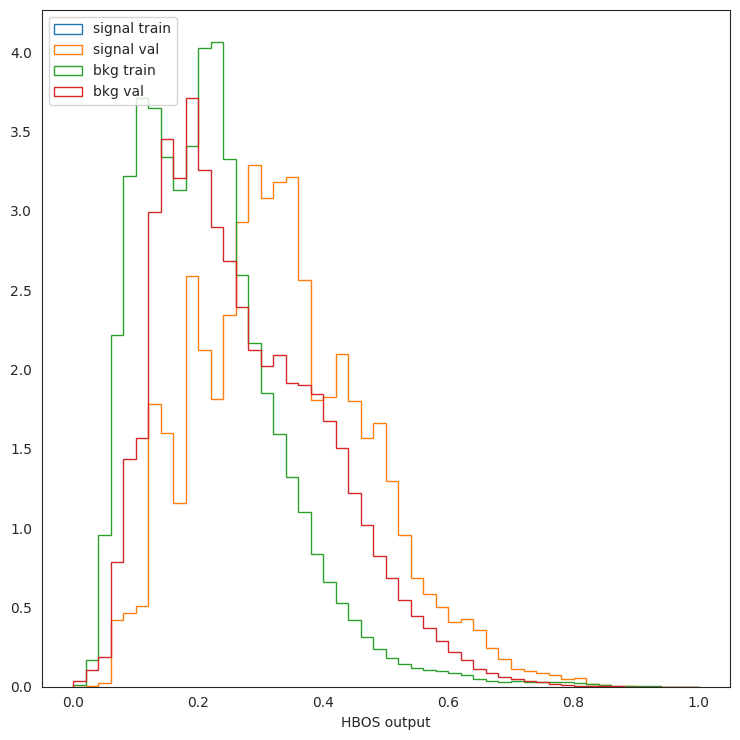

In [ ]:
bins = plt.hist(y_train_scores[np.where(y_train == 1)], bins=50, density=True, histtype='step', label='signal train')
plt.hist(y_val_scores[np.where(y_val == 1)], bins=bins[1], density=True, histtype='step', label='signal val')

plt.hist(y_train_scores[np.where(y_train == 0)], bins=50, density=True, histtype='step', label='bkg train')
plt.hist(y_val_scores[np.where(y_val == 0)], bins=bins[1], density=True, histtype='step', label='bkg val')

plt.xlabel('HBOS output')
plt.legend(loc='upper left')
plt.show()

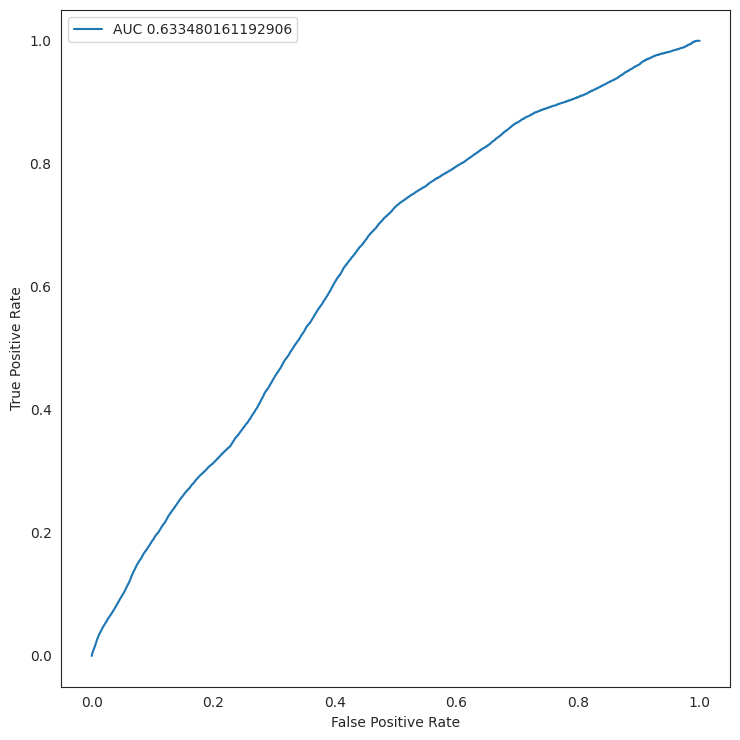

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_val, y_val_scores)
auc = roc_auc_score(y_val, y_val_scores)
plt.plot(fpr,tpr,label=f'AUC {auc}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [ ]:
y_test_pred = clf2.predict(data_test)  # outlier labels (0 or 1)
y_test_scores2 = clf2.decision_function(data_test)  # outlier scores
y_test_scores = (y_test_scores2 - y_test_scores2.min())/(y_test_scores2.max() - y_test_scores2.min()) # outlier scores as a classifier

499544
499544


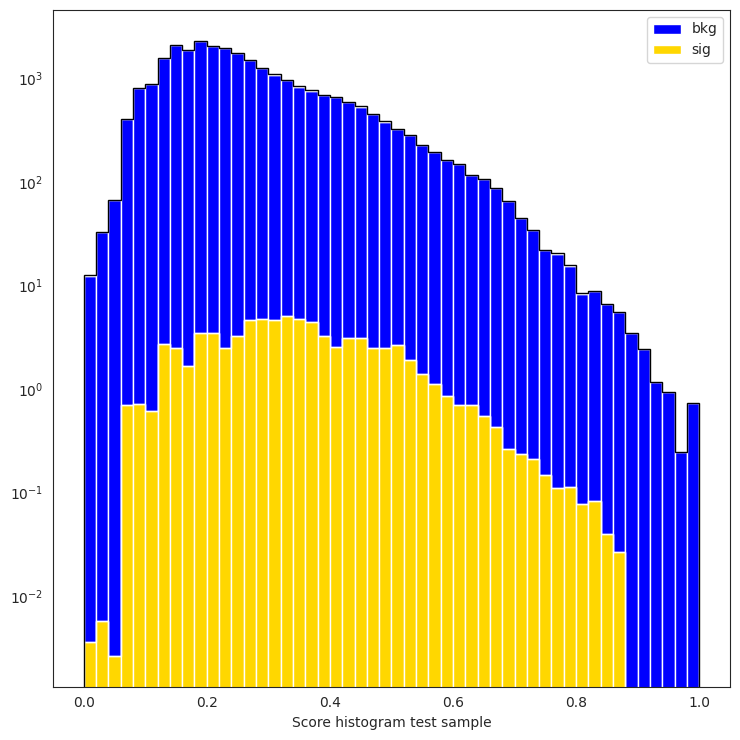

In [ ]:
y_test_scores_bkg = np.squeeze(y_test_scores[np.where(y_test == 0)])
y_test_scores_sig = np.squeeze(y_test_scores[np.where(y_test == 1)])

print(len(y_test_scores[np.where(y_test == 0)]))
print(len(test_weights_b))

bins= plt.hist(y_test_scores_bkg, bins=50, weights= test_weights_b, histtype='bar', stacked=True, fill=True, color=['blue'],label=['bkg'])
bin_counts_b, bin_edges_b, _ = plt.hist(y_test_scores[np.where(y_test == 0)],bins=bins[1],weights=test_weights_b, histtype='step', color='white')
bin_centres = (bin_edges_b[:-1] + bin_edges_b[1:]) / 2
y_error = np.sqrt(bin_counts_b)
#plt.errorbar(x=bin_centres, y=bin_counts,
#            yerr=y_error, color='black', fmt='o', capsize=2, label='data')



bins = plt.hist(y_test_scores_sig, bins=bins[1], weights= test_weights_s, histtype='bar', stacked=True, fill=True, color=['gold'],label=['sig'])
bin_counts_s, bin_edges_s , _ = plt.hist(y_test_scores[np.where(y_test == 1)],bins=bins[1],weights=test_weights_s, histtype='step', color='white')
bin_centres = (bin_edges_s[:-1] + bin_edges_s[1:]) / 2
y_error = np.sqrt(bin_counts_s)
#plt.errorbar(x=bin_centres, y=bin_counts,
#             yerr=y_error, color='black', fmt='o', capsize=2, label='data')


bin_counts_t, bin_edges_t , _ = plt.hist(y_test_scores,bins=bins[1],weights=test_weights_t, histtype='step', color='black')
bin_centres = (bin_edges_t[:-1] + bin_edges_t[1:]) / 2
y_error = np.sqrt(bin_counts_t)
#plt.errorbar(x=bin_centres, y=bin_counts,
#             yerr=y_error, color='black', fmt='o', capsize=2, label='data')

plt.legend()
plt.xlabel('Score histogram test sample')
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.show()

In [ ]:
bck = np.histogram(y_test_scores_bkg, bins=50, weights= test_weights_b)
bck_count, bck_edges = np.histogram(y_test_scores_bkg, bins=50, weights= test_weights_b)
bck_centres = (bck_edges[:-1] + bck_edges[1:])/ 2
bck_width = np.diff(bck_edges)[0]
plt.bar(bck_centres,bck_count, label = 'bkg', color = 'blue', width = bck_width)

sig = np.histogram(y_test_scores_sig, bins=50, weights= test_weights_s)
sig_count, sig_edges = np.histogram(y_test_scores_sig, bins=50, weights= test_weights_s)
plt.bar(bck_centres, sig_count, label = 'sig', color = 'gold', width = bck_width, bottom =bck[0])


tot = np.histogram(y_test_scores, bins=50, weights= test_weights_t)
tot_edges = tot[1].tolist()

plt.hist(y_test_scores, bins=bck[1],weights=test_weights_t, histtype='step',label = 'total ', color='black')

plt.legend()
plt.xlabel("Score histogram stacked")
plt.yscale('log')
plt.show()

#plt.hist([y_test_pred_bkg,y_test_pred_sig], bins=50, weights= [test_weights_s,test_weights_b], histtype='bar', stacked=True, fill=True, color=['gold','blue'],label=['bkg','sig'])
#plt.legend()
#plt.yscale('log')  # Set y-axis to logarithmic scale
#plt.show()

In [ ]:
from keras import backend
model_spec = {'channels': [{'name': 'singlechannel',
              'samples': [
              {'name': 'signal','data': sig[0].tolist() ,
               'modifiers': [{'data': None, 'name': 'mu', 'type': 'normfactor'}]},
              {'name': 'bkg','data': bck[0].tolist() ,
               'modifiers': [#{'data': None, 'name': 'bkg1_scale', 'type': 'normfactor'}, # Normalisation factor for bkg1
                            ]},
              ]
              }],
              "observations": [{ "name": "singlechannel", "data": tot[0].tolist() }],
              "measurements": [{ "name": "Measurement", "config": {"poi": "mu", "parameters": []}}],
              "version": "1.0.0",
}

workspace = pyhf.Workspace(model_spec)
model = workspace.model()

print("## Model")
print(f"  channels: {model.config.channels}")
print(f"     nbins: {model.config.channel_nbins}")
print(f"   samples: {model.config.samples}")
print(f" modifiers: {model.config.modifiers}")
print(f"parameters: {model.config.parameters}")
print(f"par. order: {model.config.par_order}")

print("\n## Model parameters")
print(f'   default: {model.config.suggested_init()}')
print(f'    bounds: {model.config.suggested_bounds()}')

In [ ]:
data = bck[0].tolist() + model.config.auxdata

best_pars = pyhf.infer.mle.fit(data=data, pdf=model)
print("\nBest fit parameters:")
for i,p in enumerate(best_pars):
  print(f'\t{model.config.par_order[i]}: {best_pars[i]:.2e}')


test_stat = "qtilde"
test_poi = 1.

# Vary mu values
poi_values = np.linspace(0.1, 5, 50)
obs_limit, exp_limits = pyhf.infer.intervals.upperlimit(data, model, poi_values, level=0.05)
print(f"Observed μ upper limit (obs): {obs_limit:.3f}, Expected μ upper limit {exp_limits[2]:.3f}")


Best fit parameters:
	mu: 0.00e+00


<ipython-input-64-43ec16e57746>:14: DeprecationWarning: pyhf.infer.intervals.upperlimit is deprecated in favor of pyhf.infer.intervals.upper_limits.upper_limit as of pyhf v0.7.0 and will be removed in pyhf v0.9.0. Please use pyhf.infer.intervals.upper_limits.upper_limit.
  obs_limit, exp_limits = pyhf.infer.intervals.upperlimit(data, model, poi_values, level=0.05)


Observed μ upper limit (obs): 3.027, Expected μ upper limit 3.027


In [ ]:
data = tot[0].tolist() + model.config.auxdata

best_pars = pyhf.infer.mle.fit(data=data, pdf=model)
print("\nBest fit parameters:")
for i,p in enumerate(best_pars):
  print(f'\t{model.config.par_order[i]}: {best_pars[i]:.2e}')


test_stat = "qtilde"
test_poi = 1.

# Vary mu values
poi_values = np.linspace(0.1, 5, 50)
obs_limit, exp_limits = pyhf.infer.intervals.upperlimit(data, model, poi_values, level=0.05)
print(f"Observed μ upper limit (obs): {obs_limit:.3f}, Expected μ upper limit {exp_limits[2]:.3f}")


Best fit parameters:
	mu: 8.02e-01


<ipython-input-65-5542503acdb2>:14: DeprecationWarning: pyhf.infer.intervals.upperlimit is deprecated in favor of pyhf.infer.intervals.upper_limits.upper_limit as of pyhf v0.7.0 and will be removed in pyhf v0.9.0. Please use pyhf.infer.intervals.upper_limits.upper_limit.
  obs_limit, exp_limits = pyhf.infer.intervals.upperlimit(data, model, poi_values, level=0.05)


Observed μ upper limit (obs): 3.613, Expected μ upper limit 3.027
